In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
# from keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from keras.models import Model
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
imgs_dir = '../../data/human-segmentation/images'
masks_dir = '../../data/human-segmentation/masks'

In [3]:
imgs_arr = np.zeros((len(os.listdir(imgs_dir)), 256, 256, 3), dtype = np.float32)
masks_arr = np.zeros((len(os.listdir(masks_dir)), 256, 256, 1), dtype = np.float32)



for index in range(len(os.listdir(imgs_dir))):
    img = load_img(os.path.join(imgs_dir, os.listdir(imgs_dir)[index]), target_size = (256, 256, 3))
    imgs_arr[index] = img_to_array(img)
    


for index in range(len(os.listdir(masks_dir))):
    img = load_img(os.path.join(masks_dir, os.listdir(masks_dir)[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    masks_arr[index] = img_to_array(img)


imgs_arr /= 255.
masks_arr /= 255.

x_train = imgs_arr[10:]
y_train = masks_arr[10:]

x_test = imgs_arr[0:10]
y_test = masks_arr[0:10]

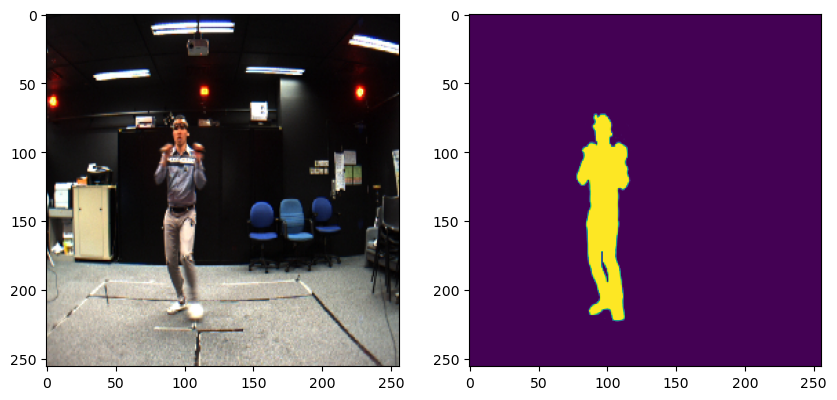

In [4]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(imgs_arr[0])
f.add_subplot(1,2, 2)
plt.imshow(masks_arr[0])
plt.show(block=True)

In [5]:
def conv_block(inputs,n_filters,max_pool=True):
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip = x
    if max_pool:
        next_layer = MaxPool2D()(x)
    else:
        next_layer = x
    return next_layer, skip

# upsampling block 
def up_block(reg_inputs,skip_inputs,n_filters):
    x = Conv2DTranspose(n_filters,3,2,padding='same')(reg_inputs)
    x = concatenate([x,skip_inputs],axis=3)
    x = conv_block(x,n_filters,max_pool=False)[0]
    return x

In [6]:
def unet(input_size=(256,256,3),number_of_classes=1):
    inputs = Input(shape=input_size)
    cb1 = conv_block(inputs,32)
    cb2 = conv_block(cb1[0],64)
    cb3 = conv_block(cb2[0],128)
    cb4 = conv_block(cb3[0],256)
    cb5 = conv_block(cb4[0],512,max_pool=False)
    
    up1 = up_block(cb5[0],cb4[1],256)
    up2 = up_block(up1,cb3[1],128)
    up3 = up_block(up2,cb2[1],64)
    up4 = up_block(up3,cb1[1],32)
    
    conv1 = Conv2D(32,3,padding='same',kernel_initializer='he_normal',use_bias=False)(up4)
    bn = BatchNormalization()(conv1)
    lrl = LeakyReLU(0.2)(bn)
    outputs = Conv2D(number_of_classes,1,padding='same',activation='sigmoid')(lrl)
    
    unet = Model(inputs=inputs,outputs=outputs)
    return unet

In [7]:
# Jaccard coeficient or IoU
def jaccard_coef(y_true,y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)-intersection+smooth)
# Jaccard loss
def jaccard_loss(y_true,y_pred,smooth=1):
    # We are multiplying IoU with -1 because we are trying to maximize the IoU so it will get bigger every iteration
    return -jaccard_coef(y_true,y_pred,smooth)

In [8]:
model = unet()

# Plotting our model
# keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     dpi=60
# )

# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 16, 16, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 512)  2359296     ['leaky_re_lu_8[0][0]']          
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 512)  2048       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 16, 16, 512)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_tr

 batch_normalization_16 (BatchN  (None, 256, 256, 32  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 256, 256, 32  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 32  9216        ['leaky_re_lu_16[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 256, 256, 32  128        ['conv2d_17[0][0]']              
 ormalizat

In [9]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss=[jaccard_loss],metrics=[jaccard_coef])

In [10]:
history = model.fit(x_train,y_train,batch_size=8,epochs=20,validation_split=0.2, verbose=1)

Epoch 1/20
119/119 [==============================] - 28s 195ms/step - loss: -0.3322 - jaccard_coef: 0.3329 - val_loss: -0.1021 - val_jaccard_coef: 0.1018
Epoch 2/20
119/119 [==============================] - 21s 174ms/step - loss: -0.7142 - jaccard_coef: 0.7152 - val_loss: -0.2279 - val_jaccard_coef: 0.2275
Epoch 3/20
119/119 [==============================] - 20s 171ms/step - loss: -0.8378 - jaccard_coef: 0.8376 - val_loss: -0.4738 - val_jaccard_coef: 0.4739
Epoch 4/20
119/119 [==============================] - 20s 172ms/step - loss: -0.8687 - jaccard_coef: 0.8687 - val_loss: -0.8623 - val_jaccard_coef: 0.8623
Epoch 5/20
119/119 [==============================] - 20s 171ms/step - loss: -0.8890 - jaccard_coef: 0.8890 - val_loss: -0.8196 - val_jaccard_coef: 0.8194
Epoch 6/20
119/119 [==============================] - 20s 170ms/step - loss: -0.8949 - jaccard_coef: 0.8950 - val_loss: -0.8574 - val_jaccard_coef: 0.8571
Epoch 7/20
119/119 [==============================] - 20s 172ms/step -

In [11]:
model.save('first_model.h5')

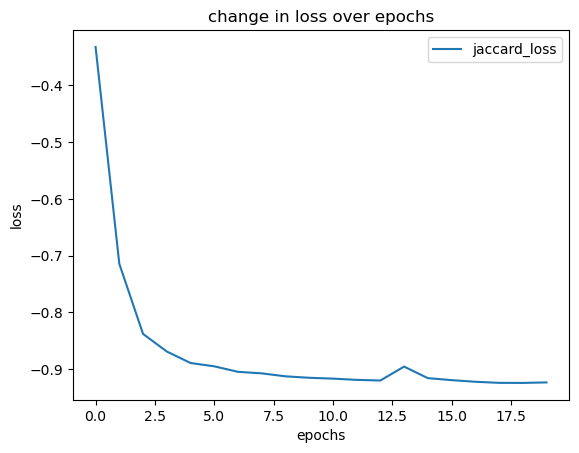

In [12]:
x = [i for i in range(20)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['jaccard_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

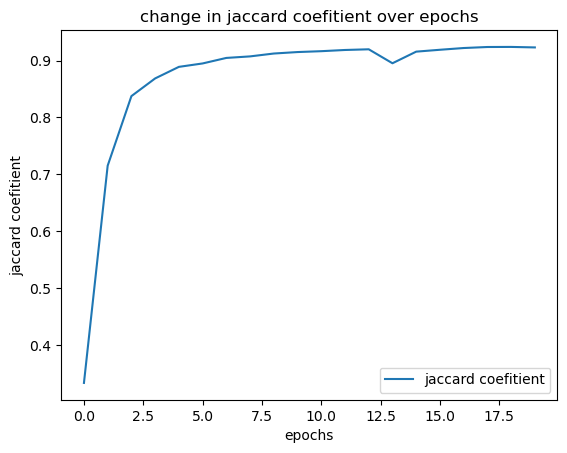

In [13]:
# Plotting IoU change over epochs, this will be same as loss just inverted so you can skip this part!
x = [i for i in range(20)]
plt.plot(x,history.history['jaccard_coef'])
plt.title('change in jaccard coefitient over epochs')
plt.legend(['jaccard coefitient'])
plt.xlabel('epochs')
plt.ylabel('jaccard coefitient')
plt.show()

In [14]:
predictions = model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [15]:
def create_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask

In [16]:
def plot_results_for_one_sample(sample_index):
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(y_test[sample_index])
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(mask)
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(x_test[sample_index]*mask)

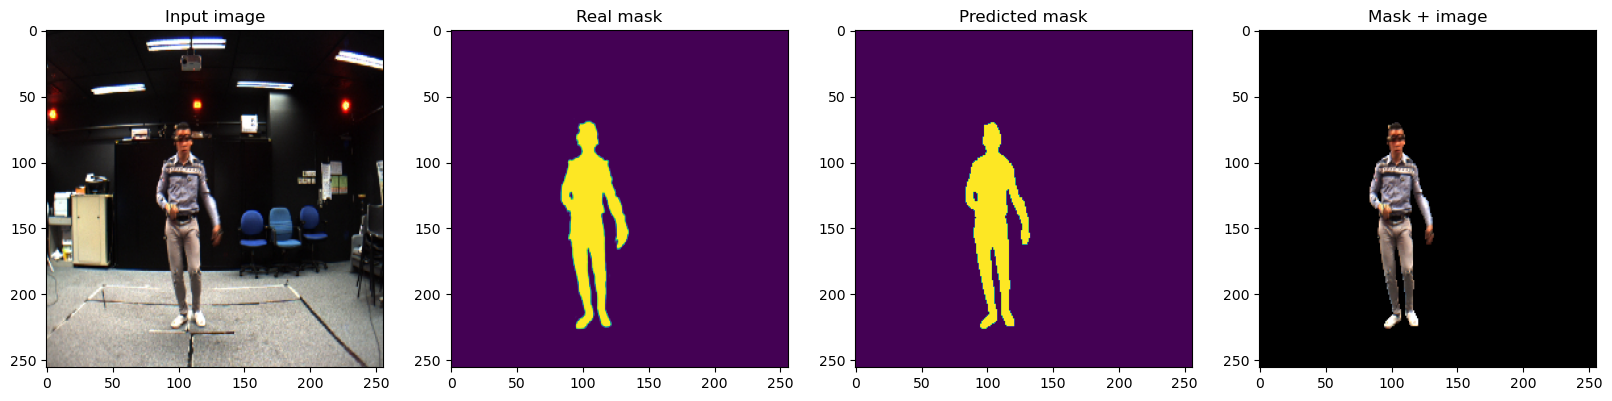

In [71]:
plot_results_for_one_sample(6)

In [40]:
img_dir = './images/'
imgs_arr = np.zeros((len(os.listdir(img_dir)), 256, 256, 3), dtype = np.float32)

for index in range(len(os.listdir(img_dir))):
    img = load_img(os.path.join(img_dir, os.listdir(img_dir)[index]), target_size = (256, 256, 3))
    imgs_arr[index] = img_to_array(img)
    

imgs_arr /= 255.

pred = model.predict(imgs_arr)

1/1 [==============================] - 1s 859ms/step


In [68]:
def predict_from_dir():
    img_dir = './images/'
    imgs_arr = np.zeros((len(os.listdir(img_dir)), 256, 256, 3), dtype = np.float32)
    
    for index in range(len(os.listdir(img_dir))):
        img = load_img(os.path.join(img_dir, os.listdir(img_dir)[index]), target_size = (256, 256, 3))
        imgs_arr[index] = img_to_array(img)
        
    def res(sample_index):
        mask = create_mask(pred[sample_index])
        f = plt.figure(figsize=(20,20))
        f.add_subplot(1,3,1)
        plt.title('Input image')
        plt.imshow(imgs_arr[sample_index])
        f.add_subplot(1,3,2)
        plt.title('Predicted mask')
        plt.imshow(mask)
        f.add_subplot(1,3,3)
        plt.title("Mask + image")
        plt.imshow(imgs_arr[sample_index]*mask)
        
    
    imgs_arr /= 255.
    
    pred = model.predict(imgs_arr)
    
    for sample in range(len(imgs_arr)):
        res(sample)

1/1 [==============================] - 0s 19ms/step


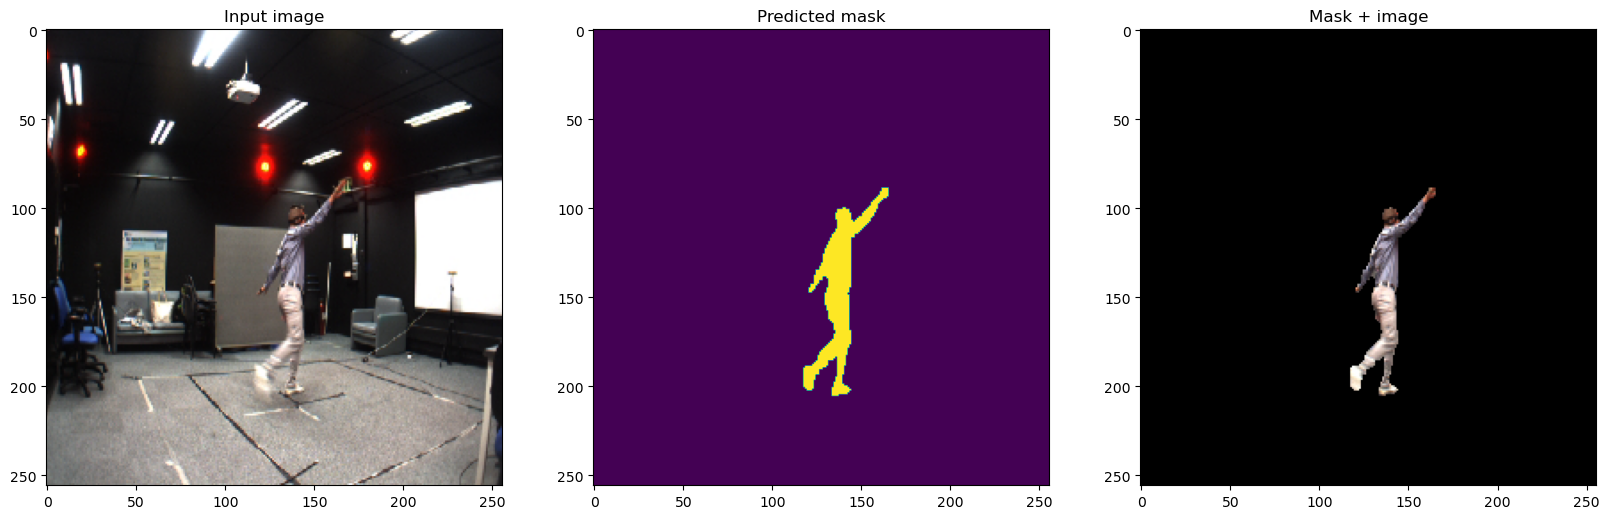

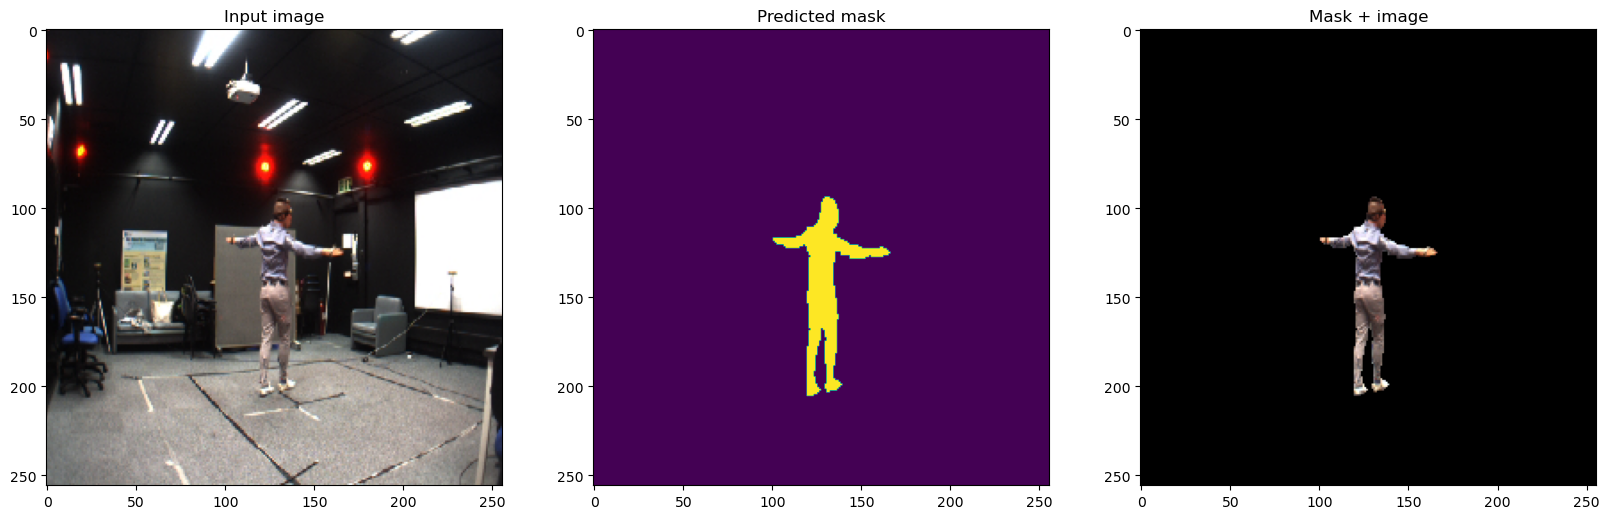

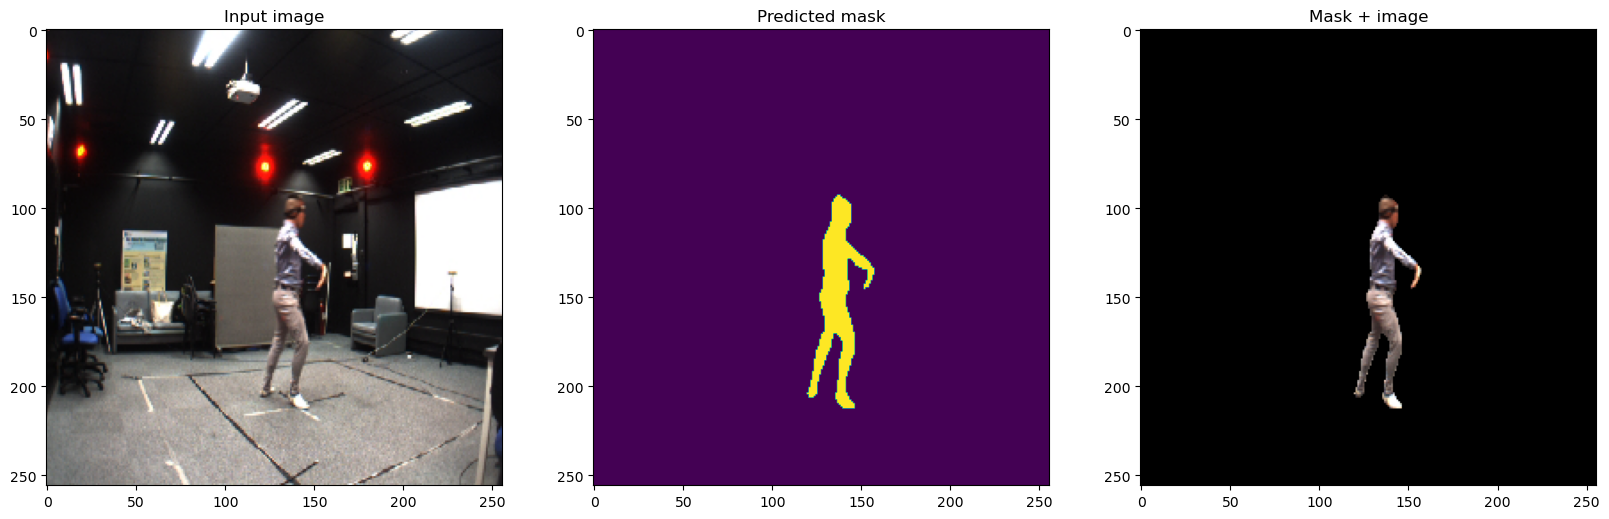

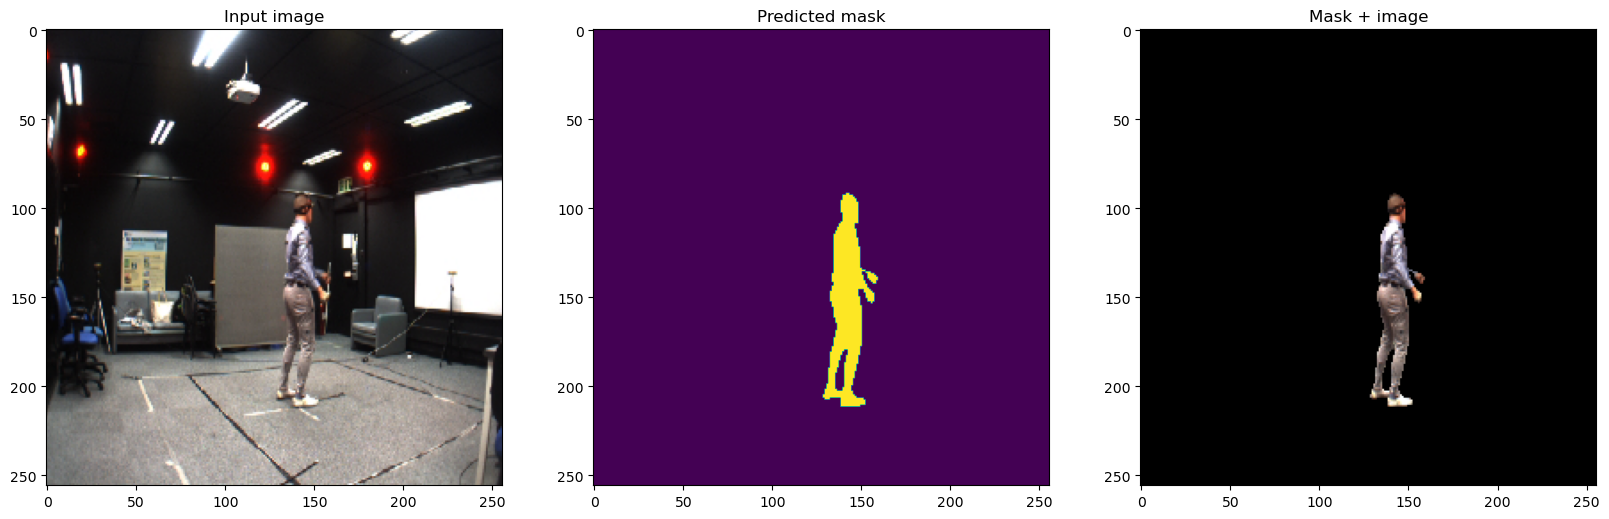

In [77]:
predict_from_dir()